## Recommender system for CareerVillage

<img src="https://www.ffwd.org/wp-content/uploads/CareerVillage-logo.png" alt="Drawing" style="width: 400px;"/>

### Problem Statement
The U.S. has almost 500 students for every guidance counselor. Underserved youth lack the network to find their career role models, making CareerVillage.org the only option for millions of young people in America and around the globe with nowhere else to turn.

To date, 25,000 volunteers have created profiles and opted in to receive emails when a career question is a good fit for them. This is where your skills come in. To help students get the advice they need, the team at CareerVillage.org needs to be able to send the right questions to the right volunteers. The notifications sent to volunteers seem to have the greatest impact on how many questions are answered.

#### Objective: 
Develop a method to recommend relevant questions to the professionals who are most likely to answer them.

## Approach: 

The approach is to develop a model that only takes into account the tags used by professionals and questions.

After browsing careervillage.org it became clear that the questions are often very short, which can be hard to process with NLP. Our claim is that e.g. a bag-of-words TFIDF would include a lot of overhead, with minimal improvement over using an efficient tag-matching system.

Furthermore users are free to add new tags in their questions, which make many questions to have very specific tags. Although professionals will be less inclined to add a lot sub-categories to their profile, we including some extra features to our model:
* For each professional the tags of the questions that he/she answered are added to his/her profile when setting up the model.
* Tags that are closely related to ones in this profile will be added as well, and contribute to a lesser extend when predicting matches.


## General outline of the model:

1. Graph network of tags in order to find related tags. Tags are related to each other if they appear in the same question. (this matrix can be recalculated every x-days/weeks/months).

2. Calculate a 'fingerprint' for each professional. This list contains the tags that user added to his/her profile, the ones of the questions he/she answered, including neighbouring tagss (although they contribute to a lesses extend).

3. For each question: tags that are added by the student are compared to the fingerprints of the professionals.
* Professionals who have the most tags in common with the question are selected by the algorithm.  

### Scoring the model

Scoring models in the challenge has proven to be difficult.
Our approach for having some kind of scoring is to:

* create a ranking for currently used model by cv: mails are send to users in a certain order, we assume that this is the ranking that is constructed by the model careervillage is currently using.

* Re-rank the CV order using our model. If the user that actually replied to a question ranks higher with our model, we can have some confidence that this model is usefull to test in production.


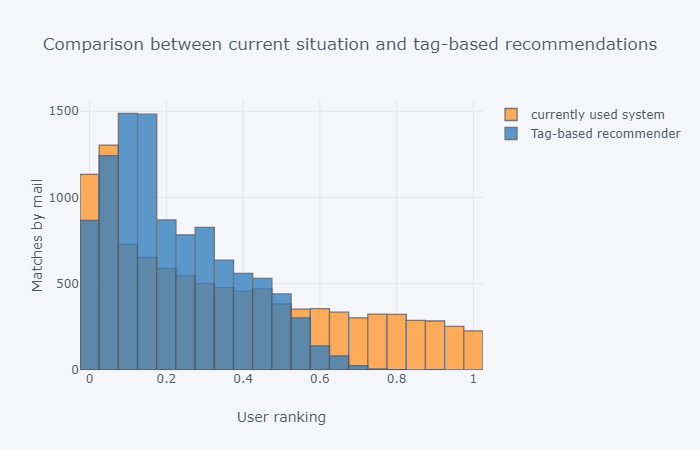

In [1]:
from IPython.display import Image
Image("../input/cvresults/cv-resultsv02.png")

#### Recommendations for further improving the model:

* Question/answer scores are not included in our model. If a professional receives a *heart* he should be higher up in the ranking for questions with related tags. 
* Weight of related tags: some tags are more related to each other then others. This can be used to enhance the 'fingerprint' of the professionals.
* Questions and replies can be scanned for tags.

#### Remarks

* We have removed the tags 'College' and 'Career' from the model. We felt that they were overly used, and can not be used to specify a certain professional.



## Packages

In [ ]:
%matplotlib inline


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

import plotly.plotly as py
import cufflinks as cf

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from wordcloud import WordCloud

## Importing CSV files

For our initial model, we will keep things simple and focus on the datasets that appear to be revelant for our recommender system.

Information on the users. Users consist of professionals & students
- **professionals**.csv: We call our volunteers "Professionals", but we might as well call them Superheroes. They're the grown ups who volunteer their time to answer questions on the site.
- **students**.csv: Students are the most important people on CareerVillage.org. They tend to range in age from about 14 to 24. They're all over the world, and they're the reason we exist!
- **tag_users**.csv: Users of any type can follow a hashtag. This shows you which hashtags each user follows.


Core of our recommendation engine: the Q&A information:

- **questions**.csv: Questions get posted by students. Sometimes they're very advanced. Sometimes they're just getting started. It's all fair game, as long as it's relevant to the student's future professional success.

- **tag_questions**.csv: Every question can be hashtagged. We track the hashtag-to-question pairings, and put them into this file.

- **answers**.csv: Answers are what this is all about! Answers get posted in response to questions. Answers can only be posted by users who are registered as Professionals. However, if someone has changed their registration type after joining, they may show up as the author of an Answer even if they are no longer a Professional.

Information on the platform: 

- **emails**.csv: Each email corresponds to one specific email to one specific recipient. The frequency_level refers to the type of email template which includes immediate emails sent right after a question is asked, daily digests, and weekly digests.

- **matches**.csv: Each row tells you which questions were included in emails. If an email contains only one question, that email's ID will show up here only once. If an email contains 10 questions, that email's ID would show up here 10 times.

- **tags**.csv: Each tag gets a name.

#### Dropped tables:

- group_memberships.csv: Any type of user can join any group. There are only a handful of groups so far.
- group.csv:  Each group has a "type"
- school_memberships.csv: Just like group_memberships, but for schools instead.
- comments.csv: Comments can be made on Answers or Questions. We refer to whichever the comment is posted to as the "parent" of that comment. Comments can be posted by any type of user. Our favorite comments tend to have "Thank you" in them :)
- question_scores.csv: "Hearts" scores for each question.
- answer_scores.csv: "Hearts" scores for each answer.

**

In [ ]:
input_dir = r'../input/data-science-for-good-careervillage'
#print(os.listdir(input_dir))
#input_dir = '' 

professionals = pd.read_csv(os.path.join(input_dir, 'professionals.csv'))
students = pd.read_csv(os.path.join(input_dir, 'students.csv'))
tag_users = pd.read_csv(os.path.join(input_dir, 'tag_users.csv'))

answers = pd.read_csv(os.path.join(input_dir, 'answers.csv'))
questions = pd.read_csv(os.path.join(input_dir, 'questions.csv'))
tag_questions = pd.read_csv(os.path.join(input_dir, 'tag_questions.csv'))

tags = pd.read_csv(os.path.join(input_dir, 'tags.csv'))
emails = pd.read_csv(os.path.join(input_dir, 'emails.csv'))
matches = pd.read_csv(os.path.join(input_dir, 'matches.csv'))

# Dropped:
# groups = pd.read_csv(os.path.join(input_dir, 'groups.csv'))
# group_memberships = pd.read_csv(os.path.join(input_dir, 'group_memberships.csv'))
# school_memberships = pd.read_csv(os.path.join(input_dir, 'school_memberships.csv'))
# comments = pd.read_csv(os.path.join(input_dir, 'comments.csv'))
# question_scores = pd.read_csv(os.path.join(input_dir, 'question_scores.csv'))
answer_scores = pd.read_csv(os.path.join(input_dir, 'answer_scores.csv'))


## Cleaning & Prejoining tables

#dtype to datetime
professionals['professionals_date_joined'] = pd.to_datetime(professionals['professionals_date_joined'])
students['students_date_joined'] = pd.to_datetime(students['students_date_joined'])
questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'])
answers['answers_date_added'] = pd.to_datetime(answers['answers_date_added'])

tag_users = tag_users.merge(tags, left_on='tag_users_tag_id',right_on='tags_tag_id', how='outer')
tag_questions = tag_questions.merge(tags, left_on ='tag_questions_tag_id',right_on='tags_tag_id', how='outer')


#tag_users.describe(include='all')
#tag_users.set_index(['tag_users_tag_id']);
#tags.set_index(['tags_tag_id']);
#tag_users.join(tags, on=['tag_users_tag_id', 'tags_tag_id'], how='inner')
#result = pd.merge(left.reset_index(), right.reset_index(), on=['key'], how='inner').set_index(['key','Y'])

# Feature Exploration, Engineering and Cleaning
## General metrics for CV: 
#### Userbase Growth:


In [ ]:
#professionals.describe()
professionals['professionals_date_joined'].dt.month

plt_profjoined = (professionals.groupby([professionals['professionals_date_joined'].map(lambda x: 100*x.year + x.quarter)]).size())#/len(professionals.professionals_date_joined))
plt_studjoined = (students.groupby([students['students_date_joined'].map(lambda x: 100*x.year + x.quarter)]).size())#/len(students.students_date_joined))

plt_data = pd.DataFrame({'professionals': plt_profjoined,
                        'students':plt_studjoined })

plt_data.cumsum().plot(kind='bar', figsize=(13, 6))
plt.xlabel('Year - Quarter')
plt.ylabel('Number of users.')
plt.title('Professionals joined over time')
plt.show()

#### Activity:


In [ ]:
#professionals.describe()

plt_questions = (questions.groupby([questions['questions_date_added'].map(lambda x: 100*x.year + x.quarter)]).size())#/len(students.students_date_joined))
plt_answers = (answers.groupby([answers['answers_date_added'].map(lambda x: 100*x.year + x.quarter)]).size())#/len(students.students_date_joined))


plt_data = pd.DataFrame({'questions': plt_questions,
                        'answers': plt_answers})


plt_data.cumsum().plot(kind='bar', figsize=(13, 6))
plt.xlabel('Year - Quarter')
plt.ylabel('Number of Prof.')
plt.title('Activity on the site')
plt.show()

#### Use of Tags

In [ ]:
cf.set_config_file(offline=True, world_readable=True, theme='pearl')

# get the number of users & questions for each tag.
plt_tag_users = tag_users.groupby([tag_users['tags_tag_name']]).size()
plt_tag_questions = tag_questions.groupby([tag_questions['tags_tag_name']]).size()

plt_data = pd.DataFrame({'user_tags': plt_tag_users,
                        'question_tags': plt_tag_questions}).reset_index()

# filter out the tags with little use (just for the visualisation)
plt_data = plt_data[(plt_data>20).all(axis=1)]

plt_data.iplot(kind='bubble', x='user_tags', y='question_tags', size='question_tags', text='tags_tag_name', color = 'blue',
             xTitle='User w Tag', yTitle='Question w Tag',title='Popular tags for users & professionals')
plt.show()


### Graph network for Tags

Our goal is to use related tags to enrich the profiles of our professionals. This method is only usefull if we can cluster tags around a 'central' topic. The plot below shows that is the case for cv.org: 

In [ ]:
tag_questions['dummy'] = 1
q_tags = tag_questions.pivot_table(index='tag_questions_question_id', columns = "tags_tag_name", values='dummy',fill_value=0)

import scipy as sp
from scipy.sparse import csr_matrix

#sparse matrix from tag matrix
sp_tags=csr_matrix(q_tags)
sp_tags = sp_tags.T.dot(sp_tags)

#print(sp_tags[:,-5])

#get the indices for the rows/cols & values:
Knz = sp_tags.nonzero()
sparserows = Knz[0]
sparsecols = Knz[1]
vals = np.empty(sparserows.shape).astype(np.float)
for i in range(len(sparserows)):
    vals[i] = sp_tags[sparserows[i],sparsecols[i]]

# Dataframe: Tag 1  / Tag 2 / nuumber of times both tags appear in the same question.
tags_NN = pd.DataFrame({'tag1': sparserows,
                        'tag2': sparsecols,
                        'n_occurances' :vals})

# Remove relations where tag1 = tag2 (connection with itself).
tags_NN= tags_NN[tags_NN.tag1 != tags_NN.tag2]
# Correct for double counts: All connections  counted twice (A-> B and B-> A)
tags_NN.drop(tags_NN.loc[tags_NN["tag2"]<tags_NN["tag1"]].index.tolist(), inplace=True)


# - - - - -
# Test with Head
# - - - - -
tags_NN = tags_NN.head(200)

#Create a network:
import networkx as nx

G_tags = nx.from_pandas_edgelist(df=tags_NN, source='tag1', target='tag2', edge_attr='n_occurances')
#G_tags.add_nodes_from(nodes_for_adding=tags_NN.tag2.tolist())

tags_NN.head();
pos = nx.spring_layout(G_tags)

plt.figure(1,figsize=(12,12))
nx.draw_networkx_nodes(G_tags, pos, alpha=0.1)
nx.draw_networkx_edges(G_tags, pos, alpha=0.1)


In the image above, who show the relation between 200 tags. We find that these appear to be clustered. A central topic can have many sub-topics. And these tags will appear together in the questions of students.

Our professionals will not assign all the different 'sub' tags to their profile. To increase our chances of matching a professional with a question we will add two things to our model: 

 - we will take into account 'neighbouring tags' when matching questions with users.
 - if a professional responds to a certain question, he will 'inherit' the corresponding tags from that question to his profile. In this way we can increase the details of our users knowledge, without the user themselves adding the related sub-tags to his/her profile.

### E-mails & Matches


In [ ]:
#Convert dates to datetime64 format
emails['emails_date_sent'] = emails['emails_date_sent'].map(lambda x: str(x)[:-9])
emails['emails_date_sent'] = pd.to_datetime(emails['emails_date_sent'],infer_datetime_format=True)

email_matches = emails.merge(matches, left_on='emails_id',right_on='matches_email_id', 
                             how='right').drop('matches_email_id',axis=1);

q_and_a =questions.merge(answers, left_on='questions_id',right_on='answers_question_id', 
                             how='outer').drop('answers_question_id',axis=1).sort_values('questions_id');

### Amount of e-mails send per question ###
emails_send = email_matches.groupby('matches_question_id').count().sort_values('emails_id',ascending=False)['emails_id']

emails_send.iplot('histogram', title = 'Number of e-mails send per question',xTitle = 'E-mails send', 
                  yTitle = 'Counts (log)',logy=True,bins=50)

### Number of answers per question ###
N_answers = q_and_a.groupby('questions_id').count()['answers_id']
N_answers=N_answers[N_answers<20]
N_answers.iplot('histogram', title = 'Answers per question',xTitle = '# Answers')


### Time between question and answer
time_qa = q_and_a['answers_date_added'] - q_and_a['questions_date_added']
time_qa.dt.days.iplot('histogram',title = 'Average time until a question is answered',xTitle = 'Days', yTitle ='Counts', logy=True, bins=50)
#time_qa.iplot(kind='histogram')

In [ ]:
# Merge [matches_question_id & email_recipient_id]  with [question_id & answer_author id] from q_and_a
# Merge: the questions for which e-mails have been send to users, with the answer table to find how many answers the e-mails have generated.
email_QA = pd.merge(email_matches, q_and_a,  how='left', left_on=['matches_question_id','emails_recipient_id'], 
                               right_on = ['questions_id','answers_author_id'])
email_QA = email_QA.drop(['emails_frequency_level','questions_date_added','questions_body','answers_body','questions_id'], 
                                               axis=1)

# Converting dates to datetime type takes a long time, quick and dirty method to get the months:
email_QA['emails_ym_sent'] = email_QA['emails_date_sent'].map(lambda x: str(x)[:-12])
mails_send = email_QA.groupby(email_QA['emails_ym_sent']).count(); #.dropna())/len(email_QA).groupby('emails_date_sent')
mails_send = mails_send['emails_id']
mails_answered = email_QA.dropna()
mails_answered = mails_answered.groupby('emails_ym_sent').count();
mails_answered = mails_answered['emails_id']

#Bar plot - howmany people actually responded after receiving an an e-mail:
plot_mail_response = pd.DataFrame({'send': mails_send,
                        'answered': mails_answered})
plot_mail_response.iplot(kind='bar',bins=10,barmode='stack',title='Numer of e-mails over time: send out and resulting in a reply',yTitle='e-mail count')

#Bar plot - ratio of the people that answered a question after receiving an e-mail.
plt_ratio = mails_answered/mails_send
plt_ratio.iplot(kind='bar',title='Effectiveness of mails being send out',xTitle='Time',yTitle='% of mails that trigger a response')
print('Effectiveness of e-mails', plt_ratio.mean())

#### Takeaway from the plots:

- Symmetric usergrow in professionals and students.
- On average, 2 answers per question.
- The tag 'college' is overly used in users, and questions. 
- The effectiveness of sending an email is currently around 1%.

# Careervillage ranking of professionals


We assume that the ranking that is currently used by careervillage corresponds to time the e-mail was send to a specific professional.
e.g. 50th person to receive an e-mail from carreervillage about a certain question is ranked '50'.

In [ ]:
# Reconstruct the ranking that was used by carreervillage
# Create a ranking for each question: #e.g. 50th person to be send an e-mail answered --> ranking = 50.
cv_communication = email_QA[['matches_question_id','emails_recipient_id','emails_date_sent','answers_date_added']];

# 1. Sort by question and by date
cv_communication = cv_communication.sort_values(by=['matches_question_id','emails_date_sent'])
# hardcode the index counter, we will use this column to calculate the ranking of the professional that replied.
cv_communication['row_counter'] = range(len(cv_communication))

# 2. Get the index of the first answer:
cv_rank_index = cv_communication.groupby(["matches_question_id"], sort=False)['answers_date_added'].min();
cv_rank_index = cv_rank_index.dropna().to_frame()
#merge back to get the row index
cv_rank_index = pd.merge(cv_rank_index, cv_communication,  how='left', left_on=['matches_question_id','answers_date_added'], 
                               right_on = ['matches_question_id','answers_date_added'])


# 3. Index of the first mail that was send for this Q:
cv_ref_index = pd.DataFrame(cv_communication.groupby(["matches_question_id"], sort=False)['emails_date_sent'].min());

 #merge back to get the row index
cv_ref_index = pd.merge(cv_ref_index, cv_communication,  how='left', left_on=['matches_question_id','emails_date_sent'], 
                               right_on =['matches_question_id','emails_date_sent'])
cv_ref_index = pd.DataFrame(cv_ref_index.groupby(["matches_question_id"], sort=False)['row_counter'].min());


# 4. Take the difference in index between the row with question id & and the answer.
cv_ranking = cv_rank_index.merge(cv_ref_index, how='left', left_on=['matches_question_id'], right_on=['matches_question_id'])


#merge the two dataframes:
cv_ranking["Ranking"] = cv_ranking['row_counter_x'] - cv_ranking['row_counter_y']
cv_ranking = cv_ranking.drop(['row_counter_x','row_counter_y','emails_recipient_id'],axis=1);

# 5. Add the total number of e-mails send to cv_ranking
cv_nmails = cv_communication.drop(['emails_date_sent','answers_date_added','row_counter'],axis=1).groupby(["matches_question_id"]).count()
cv_nmails.rename(columns={'emails_recipient_id': 'Total mails sent'}, inplace=True)
cv_ranking = cv_ranking.merge(cv_nmails, how='left', left_on=['matches_question_id'], right_on = ['matches_question_id'])

#plot
cv_ranking['rank_frac_cv'] = cv_ranking['Ranking']/cv_ranking['Total mails sent']
cv_ranking['rank_frac_cv'].iplot(kind='histogram',title='Ranking vs chance to answer to an e-mail for the CVs matching algorithm',yTitle='answered to question',
                                 xTitle='Ranking of user / total mails send')

### Scoring of tag-Based recommender system

For each question, professionals that were e-mailed by cv are re-ranked according to our tag-based recommender system. If users that answered are higher ranked, we can conclude that the model is effective.

Note: 
* this is not a 'real scoring' of the model, as running the model in production will e-mail users that have not been considered before. 
* We import df_output.csv here, this is the file created by the script (complete model) at the end of this notebook.

In [ ]:
input_dir2 = '../input/cvresultslarge'

df_output = pd.read_csv(os.path.join(input_dir2, 'df_output_large.csv'))
df_output = df_output.dropna()
rank_comparisson = pd.merge(df_output, cv_ranking,  how='inner', left_on='Question_ID', 
                               right_on = 'matches_question_id')

rank_comparisson['model_vs_cv'] = rank_comparisson['Ranking model']/rank_comparisson['Ranking']
rank_comparisson['model_vs_cv'] = rank_comparisson['model_vs_cv'][(rank_comparisson['model_vs_cv']<12)]
rank_comparisson['model_vs_cv'].iplot(kind='histogram',title='Model vs CV (smaller[<1] is better)',bins=60, xTitle='Rank tag-based recommender / Rank CV', yTitle='# questions')

rank_comparisson['rank_frac_cv'] = rank_comparisson['Ranking']/rank_comparisson['Total mails sent']
rank_comparisson['rank_frac_model'] = rank_comparisson['Ranking model']/rank_comparisson['Total mails sent']

plt_ranks =  pd.DataFrame({'currently used system': rank_comparisson['rank_frac_cv'],
                        'Tag-based recommender': rank_comparisson['rank_frac_model']})

plt_ranks.iplot(kind='histogram', bins=20,xTitle = 'User ranking', yTitle='Matches by mail',title='Comparison between current situation and tag-based recommendations')

We see that after re-ranking the users with our model, the professionals that answered to e-mails are ranked significantly higher. This already cuts back about 50% of the mails that are currently send out. This gives reason to believe that using this model on the full set of professionals, a larger user-response rate can be achieved.

# A Tag-based recommender for cv - complete code:

Below you can find the complete script that:
* Enriches the profile of professionals with the tags of questions they responded to.
* Creates a tag-tag relational matrix to take into account neighbours.
* Creates a 'fingerprint' for each professional
* Creates a ranking of professionals for a certain question
* Tests the model by re-ranking the professionals that have been e-mailed by cv.org.

In [ ]:
'''

# Exploring the data
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
import time
import sys

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)
datadir = r'../input'

read_data = True  # Always true
preprocess_data = True
recalculate_professionals_profiles = True  # True: Run only once and save the data. Slow. False: The second time you can put this to false and just load the data.

# Reading csv files
if read_data:
    # Persons
    professionals = pd.read_csv(os.path.join(datadir, 'professionals.csv'))
    students = pd.read_csv(os.path.join(datadir, 'students.csv'))
    tag_users = pd.read_csv(os.path.join(datadir, 'tag_users.csv'))
    # Questions
    questions = pd.read_csv(os.path.join(datadir, 'questions.csv'))
    answers = pd.read_csv(os.path.join(datadir, 'answers.csv'))
    tag_questions = pd.read_csv(os.path.join(datadir, 'tag_questions.csv'))
    question_scores = pd.read_csv(os.path.join(datadir, 'question_scores.csv'))
    answer_scores = pd.read_csv(os.path.join(datadir, 'answer_scores.csv'))
    emails = pd.read_csv(os.path.join(datadir, 'emails.csv'))
    matches = pd.read_csv(os.path.join(datadir, 'matches.csv'))
    tags = pd.read_csv(os.path.join(datadir, 'tags.csv'))
    print('Number of professionals: ' + str(len(professionals)))
    print('Number of students: ' + str(len(students)))
    print('Number of tag_users: ' + str(len(tag_users)))
    print('Number of questions: ' + str(len(questions)))
    print('Number of answers: ' + str(len(answers)))
    print('Number of tag_questions: ' + str(len(tag_questions)))
    print('Number of question_scores: ' + str(len(question_scores)))
    print('Number of answer_scores: ' + str(len(answer_scores)))
    print('Number of emails: ' + str(len(emails)))
    print('Number of matches: ' + str(len(matches)))

def append_question_tags_to_professionals(questions, answers, tag_questions, tag_users, tags):
    # Assign the tags to professionals which belong to questions they replied to in the past
    tag_users = tag_users.merge(tags, left_on='tag_users_tag_id', right_on='tags_tag_id', how='outer')
    tag_questions = tag_questions.merge(tags, left_on='tag_questions_tag_id', right_on='tags_tag_id', how='outer')
    q_and_a = questions.merge(answers, left_on='questions_id', right_on='answers_question_id',
                              how='outer').drop('answers_question_id', axis=1).sort_values('questions_id');
    q_and_a = q_and_a.drop(
        columns=['questions_author_id', 'questions_date_added', 'questions_title', 'questions_body', 'answers_body',
                 'answers_date_added'])
    prof_c_tags = pd.merge(tag_questions, q_and_a, how='left', left_on='tag_questions_question_id',
                           right_on='questions_id')
    prof_c_tags = prof_c_tags.drop(columns=['tag_questions_question_id', 'answers_id', 'questions_id'])
    prof_c_tags = pd.DataFrame({'tag_users_tag_id': prof_c_tags['tag_questions_tag_id'],
                                'tag_users_user_id': prof_c_tags['answers_author_id'],
                                'tags_tag_id': prof_c_tags['tags_tag_id'],
                                'tags_tag_name': prof_c_tags['tags_tag_name']
                                })
    tag_users = tag_users.append(prof_c_tags)
    return tag_users

if preprocess_data:
    professionals = professionals.drop(['professionals_headline', 'professionals_industry'], axis=1)
    professionals = professionals.fillna('')

    #Print most frequent tags
    most_frequent_tags = tags.set_index('tags_tag_id')
    most_frequent_tags['counts'] = tag_questions['tag_questions_tag_id'].value_counts()
    most_frequent_tags.sort_values(by='counts', ascending=False)
    #The most frequent tags '27490' and '129' correspond to 'college' and 'career'. These are not too relevant
    # and can better be removed for improved model performance
    tag_users = append_question_tags_to_professionals(questions, answers, tag_questions, tag_users, tags)
    tags = tags[(tags.tags_tag_id != '27490') & (tags.tags_tag_id != '129')]
    tag_users = tag_users[(tag_users.tag_users_tag_id != '27490') & (tag_users.tag_users_tag_id != '129')]
    tag_questions = tag_questions[(tag_questions.tag_questions_tag_id != '27490') & (tag_questions.tag_questions_tag_id != '129')]
    unique_questions = list(set(tag_questions['tag_questions_question_id'].values))
    matches = matches.set_index('matches_question_id').loc[unique_questions].reset_index()

    # Filter tags_users so that it only contains professionals which have tags: tag_users_professionals_only
    tag_users_professionals_only = \
    pd.merge(tag_users, professionals, how='left', left_on='tag_users_user_id', right_on='professionals_id').dropna(
        axis=0)[['tag_users_tag_id', 'tag_users_user_id']]
    tag_questions = tag_questions.set_index('tag_questions_question_id')

def create_tagMatrix(df_tags, content='', n_rows=[]):
    if content == 'questions':
        dfindex = "tag_questions_question_id"
        dfcolumns = "tag_questions_tag_id"
    elif content == 'users':
        dfindex = "tag_users_user_id"
        dfcolumns = "tag_users_tag_id"

    df_tags['dummy'] = 1
    df_QT = df_tags.pivot_table(index=dfindex, columns=dfcolumns, values='dummy').fillna(0)
    if n_rows == []:
        n_rows = len(df_QT)
    QT = df_QT.head(n_rows)
    tag_list = list(QT.columns)

    # Count co-occurrence of the tags from questions
    print('... Create co-occurence matrix ...')
    QT_sparse = sparse.csr_matrix(QT)
    TT_sparse = QT_sparse.transpose().dot(QT_sparse).tocsr()
    TT_sparse.setdiag(0)
    TT_sparse.eliminate_zeros()
    TT_sparse = sparse.csr_matrix(
        (TT_sparse.transpose() / TT_sparse.sum(axis=0)).transpose())  # Now the sum of every row equals 1

    # Make a matrix with ones on the diagonal and reduce the influence of neighbors.
    print('... Combining sparse matrices ...')
    TT_sparse = tune_TT(TT_sparse)

    # Check matrix with excel (don't do for 16000 columns!!)
    if content == 'users':
        print('... Write quality check to excel ...')
        df = pd.DataFrame(TT_sparse.todense())
        filepath = 'my_excel_file.xlsx'
        df.iloc[:100, :100].to_excel(filepath, index=False)

    df_TT = pd.DataFrame(TT_sparse.todense(), index=tag_list, columns=tag_list).fillna(0)
    return df_TT  # A matrix with in the rows the tags, and in the columns the co-occurrence of the tags. The sum of values in a row equals 1.

def tune_TT(TT_sparse, neighbor_reduction_factor=0.5):
    # First order neighbor implementation: divide influence of the neighbors by 2 and add ones to the diagonal of the matrix
    TT_sparse = TT_sparse * neighbor_reduction_factor
    # To take into account also the second order neighbors, you can add  "  + TT_sparse.multiply(TT_sparse) * neighbor_reduction_factor**2  "
    TT_sparse.setdiag(1)
    return TT_sparse

def get_tagvals(df, row):
    # Returns a list of tags that is associated with a row from the TT_professionals dataframe
    rownr = row['rownumber'].astype(int)
    tagvals = list(pd.Series(df.columns[:-1]).values[df.iloc[rownr, :-1].values.astype(bool)])
    return tagvals

def get_profile(df_TT, tags):
    # Returns the profile of a question, given a question with several tags
    profile = df_TT.loc[tags, :].sum()
    profile = profile / max(
        profile)  # Now the strongest tags will be (nearly) equal to one, which makes them comparable with users
    return profile

def create_TT_matrices(tag_list, tag_questions, tag_users_professionals_only):
    # Create a dataframe with co-occurrence of tags
    print('Start questions')
    df_TT_questions = create_tagMatrix(tag_questions, content='questions')
    df_TT_questions = df_TT_questions.reindex(columns=tag_list,
                                              fill_value=0)  # Add all tags to the columns, not just questions or users
    print('Start professionals')
    df_TT_professionals = create_tagMatrix(tag_users_professionals_only, content='users')
    df_TT_professionals = df_TT_professionals.reindex(columns=tag_list, fill_value=0)
    return df_TT_questions, df_TT_professionals

tag_list = sorted(list(tags['tags_tag_id'].values))
df_TT_questions, df_TT_professionals = create_TT_matrices(tag_list, tag_questions, tag_users_professionals_only)

def create_professionals_profiles(tag_users_professionals_only, df_TT_professionals):
    # Create a dataframe with the tagprofiles of all professionals
    df_tags_professionals = tag_users_professionals_only.pivot_table(index='tag_users_user_id',
                                                                     columns='tag_users_tag_id', values='dummy').fillna(
        0)
    df_tags_professionals = df_tags_professionals.reindex(columns=tag_list,
                                                          fill_value=0)  # Add all tags (empty columns)
    df_tags_professionals['rownumber'] = range(
        len(df_tags_professionals))  # Add a column with row numbers for allowing lambda function usage
    #df_tags_professionals = df_tags_professionals.head(5000)  # For testing: use only n professionals from the database
    professionals_profiles = df_tags_professionals.apply(
        lambda row: get_profile(df_TT_professionals, get_tagvals(df_tags_professionals, row)), axis=1)
    professionals_profiles_sparse = scipy.sparse.csr.csr_matrix(professionals_profiles)
    df_tags_professionals = df_tags_professionals.drop(['rownumber'], axis=1)
    return professionals_profiles_sparse, df_tags_professionals

if recalculate_professionals_profiles:
    print(
        ' ... Recalculating professionals profiles, this can take about 10 minutes for the complete dataset ... ')
    professionals_profiles_sparse, df_tags_professionals = create_professionals_profiles(tag_users_professionals_only,
                                                                                         df_TT_professionals)
    print(' ... Saving the professionals profiles ... ')
    sparse.save_npz("professionals_profiles.npz", professionals_profiles_sparse)
else:
    print(' ... Loading the professionals profiles ... ')
    professionals_profiles_sparse = sparse.load_npz("professionals_profiles.npz")
    df_tags_professionals = tag_users_professionals_only.pivot_table(index='tag_users_user_id',
                                                                     columns='tag_users_tag_id', values='dummy').fillna(
        0)
    df_tags_professionals = df_tags_professionals.reindex(columns=tag_list,
                                                          fill_value=0)  # Add all tags (empty columns)

def costfunction(professionals_profiles_sparse, question_profile_sparse, profs_list):
    question_profile_sparse = scipy.sparse.vstack([question_profile_sparse] * professionals_profiles_sparse.shape[0])
    minmatrix = scipy.sparse.csr_matrix.minimum(professionals_profiles_sparse,
                                                question_profile_sparse) - question_profile_sparse
    minmatrix.data **= 2  # Square all elements of matrix
    cost = pd.Series(index=profs_list, data=np.squeeze(np.asarray(np.sum(minmatrix, axis=1))))
    return cost


#recommended_profs = get_best_profs(question_tags, professionals_profiles_reduced, profs_list)

def get_best_profs(testquestion_tags, professionals_profiles_sparse, profs_list):
    # Test a question and return the best matching professionals sorted from best to worst
    question_profile_sparse = scipy.sparse.csr.csr_matrix(get_profile(df_TT_questions, testquestion_tags))
    profranking = costfunction(professionals_profiles_sparse, question_profile_sparse, profs_list)
    recommended_profs=profranking.sort_values()
    return recommended_profs

df_TT_professionals = None  # Clear for memory

def merge_question_matrices(emails, matches, questions, answers):
    email_matches = emails.merge(matches, left_on='emails_id', right_on='matches_email_id',
                                 how='right').drop('matches_email_id', axis=1)
    q_and_a = questions.merge(answers, left_on='questions_id', right_on='answers_question_id',
                              how='outer').drop('answers_question_id', axis=1).sort_values('questions_id')
    email_QA = pd.merge(email_matches, q_and_a, how='left', left_on=['matches_question_id', 'emails_recipient_id'],
                        right_on=['questions_id', 'answers_author_id'])
    email_QA = email_QA.drop(
        ['emails_id', 'emails_date_sent', 'questions_author_id', 'questions_title', 'answers_id', 'answers_date_added',
         'emails_frequency_level', 'questions_date_added', 'questions_body', 'answers_body'], axis=1)
    email_QA['answers_author_id'] = email_QA['answers_author_id'].notna()
    email_QA = email_QA.set_index('matches_question_id')
    return email_QA
email_QA = merge_question_matrices(emails, matches, questions, answers)
unique_questions = list(set(email_QA.index))

answers_reduced = answers.drop(['answers_id', 'answers_date_added', 'answers_body'], axis=1)
answers_reduced = answers_reduced.set_index(['answers_question_id'])

def best_ranking(recommended_profs, profs_list, question, answers_further_reduced):
    #Returns the value of the best ranked professional of the professionals that replied to the question
    profs_who_replied = pd.Series(answers_further_reduced['answers_author_id'][question])
    ranking = pd.DataFrame(recommended_profs).reindex(index=profs_list, columns=['ranking'])
    ranking['ranking']=range(len(ranking))
    ranking=ranking.loc[list(profs_who_replied.values),:].dropna()
    return min(ranking.ranking.values)

print('... Starting for loop ...')
df_output = pd.DataFrame(index = unique_questions, columns=['Ranking model', 'Total sent'])
df_tags_professionals['rownumber'] = range(len(df_tags_professionals))  # Add a column with row numbers for allowing lambda function usage
for rownr, question in enumerate(unique_questions):
    question_tags = pd.Series(tag_questions.loc[question,'tag_questions_tag_id']).values
    if email_QA.loc[question,'answers_author_id'].sum() > 0:
        execute_ranking = True
    else:
        execute_ranking = False

    profs_list = list(email_QA.loc[email_QA.index == question, 'emails_recipient_id'].values)  # The list of professionals who received this question
    profs_list = list(set(profs_list)) #remove duplicates
    profs_list = list(np.intersect1d(np.array(profs_list), answers_reduced['answers_author_id'].values)) #Contains only profs who actually answered a question
    df_output['Total sent'][question] = len(profs_list)
    if execute_ranking:
        profindices = df_tags_professionals.reindex(index=profs_list, columns=['rownumber'])[
            'rownumber'].values  # The row indices of these professionals in the prof lookup table
        profs_list = list(np.array(profs_list)[~np.isnan(profindices)])
        answers_further_reduced = answers_reduced.reset_index().set_index('answers_author_id').loc[profs_list,
                                  :].reset_index().set_index('answers_question_id') #Contains only answers from profs in the prof_list
        profindices = profindices[~np.isnan(profindices)]
        professionals_profiles_reduced = professionals_profiles_sparse[profindices]
        recommended_profs = get_best_profs(question_tags, professionals_profiles_reduced, profs_list)

        df_output['Ranking model'][question] = best_ranking(recommended_profs, profs_list, question, answers_further_reduced)
    else:
        '' #A question without answers was encountered

df_output.to_csv('df_output.csv')

'''
